In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import math

def get_label_quadrant(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 1, 20)

    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=50, minLineLength=100, maxLineGap=20)
    lines = [(line[0]) for line in lines]
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(image, (x1, y1), (x2, y2), (np.random.randint(255), np.random.randint(255), np.random.randint(255)), 2)


    def get_slope(line):
        if line[2] == line[0]:
            # If the x-coordinates are equal, avoid division by zero
            return np.append(line, [0, np.sqrt((line[2] - line[0]) ** 2) + (line[3] - line[1]) ** 2]).astype(int)
        else:
            return np.append(line, [abs((line[3] - line[1]) / (line[2] - line[0])), np.sqrt((line[2] - line[0]) ** 2) + (line[3] - line[1]) ** 2]).astype(int)


    angle_len_lines = []
    for line in lines:
        angle_len_lines.append(get_slope(line))
    angle_len_lines = np.array(angle_len_lines).astype(int)
    angle_len_lines = angle_len_lines[angle_len_lines[:, 4].argsort()]



    def distance_between_points(x1, y1, x2, y2):
        return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def combine_lines(lines):
        grouped_lines = {}

        for line in lines:
            x1, y1, x2, y2, slope, length = line

            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2

            slope_key = round(slope, 2)

            if slope_key in grouped_lines:
                merged = False
                for existing_line in grouped_lines[slope_key]:
                    existing_center_x = (existing_line[0] + existing_line[2]) / 2
                    existing_center_y = (existing_line[1] + existing_line[3]) / 2

                    dist = distance_between_points(center_x, center_y, existing_center_x, existing_center_y)

                    if dist <= 25:#controls how close the lines have to be to count as one
                        if length > existing_line[5] or (abs(slope) < abs(existing_line[4]) and slope != 0):
                            existing_line[:] = line
                        merged = True
                        break
                if not merged:
                    grouped_lines[slope_key].append(line)
            else:
                grouped_lines[slope_key] = [line]

        combined_lines = [line for group in grouped_lines.values() for line in group]

        return combined_lines

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    for line in combine_lines(angle_len_lines):
        x1, y1, x2, y2, _, _ = line
        cv2.line(image, (x1, y1), (x2, y2), (np.random.randint(255), np.random.randint(255), np.random.randint(255)), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    lines_list= np.array(combine_lines(angle_len_lines))[:,:4]
    lines_list = np.column_stack((lines_list, list(range(len(lines_list)))))

    def are_close(p1, p2, threshold=25):
        return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) <= threshold


    G = nx.Graph()

    for line in lines_list:
        for line_2 in lines_list:
            if str(line_2) == str(line):
                pass
            p1=(line[0], line[1])
            p2=(line[2], line[3])
            p3=(line_2[0], line_2[1])
            p4=(line_2[2], line_2[3])
            if are_close(p1, p3) or are_close(p1,p4) or are_close(p2, p3) or are_close(p2, p4):
                G.add_edge(line[4], line_2[4])
    cycles = nx.simple_cycles(G)
    cycles_of_length_4 = [cycle for cycle in cycles if len(cycle) == 4]

    box_centers = []
    box_edges=[]
    for cycle in cycles_of_length_4:# this needs to be fixed it is not picking
        x_point= np.mean([np.mean([lines_list[i][0],lines_list[i][2]])  for i in cycle])
        y_point= np.mean([np.mean([lines_list[i][1],lines_list[i][3]])  for i in cycle])
        x_point_top= np.max([np.max([lines_list[i][0],lines_list[i][2]])  for i in cycle])
        y_point_top= np.max([np.max([lines_list[i][1],lines_list[i][3]])  for i in cycle])
        x_point_min= np.min([np.min([lines_list[i][0],lines_list[i][2]])  for i in cycle])
        y_point_min= np.min([np.min([lines_list[i][1],lines_list[i][3]])  for i in cycle])
        box_centers.append([x_point, y_point])
        box_edges.append([[x_point_min, y_point_top], [x_point_top, y_point_min]])



    image_colors = []
    image = cv2.imread(image_path)

    for point in box_centers:
        image_colors.append([image[int(point[1]), int(point[0])][2], image[int(point[1]), int(point[0])][1], image[int(point[1]), int(point[0])][0]])
    image_colors# see the rgb color of the center of each box, can be used in the future for referencing if the code is white to a brown box

    def is_point_inside_box(point, box):
        (x, y), ((x1, y1), (x2, y2)) = point, box
        min_x = min(x1, x2)
        max_x = max(x1, x2)
        min_y = min(y1, y2)
        max_y = max(y1, y2)
        
        return min_x <= x <= max_x and min_y <= y <= max_y

    insides = []
    for i in range(len(cycles_of_length_4)):
        for j in range(len(cycles_of_length_4)):
            if is_point_inside_box(box_centers[j], box_edges[i]) and i!=j:
                insides.append([i,j])

    quadrant = np.where(np.multiply(np.array(box_centers[insides[0][1]])-np.array(box_centers[insides[0][0]]),np.array([1,-1]))> 0, 1, -1)

    if quadrant[0] == 1:
        if quadrant[1] == 1:
            print('label on top right')
        else:
            print('label on bottom right')
    else:
        if quadrant[1] == 1:
            print('label on top left')
        else:
            print('label on bottom left')


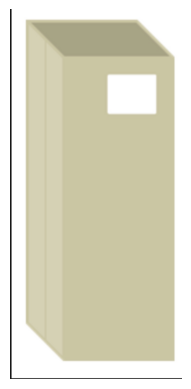

label on top right


In [28]:
image_path = r'test_box4.jpg'
get_label_quadrant(image_path)

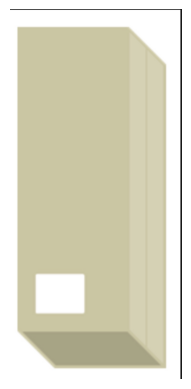

In [5]:
box_number = '2'
image = cv2.imread(r'test_box'+box_number+'.jpg')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [6]:
image = cv2.imread(r'test_box'+box_number+'.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 1, 20)

lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=50, minLineLength=100, maxLineGap=20)
lines = [(line[0]) for line in lines]
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(image, (x1, y1), (x2, y2), (np.random.randint(255), np.random.randint(255), np.random.randint(255)), 2)


In [7]:
def get_slope(line):
    return np.append(line, [abs((line[3]-line[1])/(line[2]-line[0])), np.sqrt((line[2]-line[0])**2)+(line[3]-line[1])**2]).astype(int)

In [8]:
angle_len_lines = []
for line in lines:
    angle_len_lines.append(get_slope(line))
angle_len_lines = np.array(angle_len_lines).astype(int)
angle_len_lines = angle_len_lines[angle_len_lines[:, 4].argsort()]


C:\Users\ethan\AppData\Local\Temp\ipykernel_9572\1923115556.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return np.append(line, [abs((line[3]-line[1])/(line[2]-line[0])), np.sqrt((line[2]-line[0])**2)+(line[3]-line[1])**2]).astype(int)
C:\Users\ethan\AppData\Local\Temp\ipykernel_9572\1923115556.py:2: RuntimeWarning: invalid value encountered in cast
  return np.append(line, [abs((line[3]-line[1])/(line[2]-line[0])), np.sqrt((line[2]-line[0])**2)+(line[3]-line[1])**2]).astype(int)


In [9]:
def distance_between_points(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def combine_lines(lines):
    grouped_lines = {}

    for line in lines:
        x1, y1, x2, y2, slope, length = line

        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        slope_key = round(slope, 2)

        if slope_key in grouped_lines:
            merged = False
            for existing_line in grouped_lines[slope_key]:
                existing_center_x = (existing_line[0] + existing_line[2]) / 2
                existing_center_y = (existing_line[1] + existing_line[3]) / 2

                dist = distance_between_points(center_x, center_y, existing_center_x, existing_center_y)

                if dist <= 25:#controls how close the lines have to be to count as one
                    if length > existing_line[5] or (abs(slope) < abs(existing_line[4]) and slope != 0):
                        existing_line[:] = line
                    merged = True
                    break
            if not merged:
                grouped_lines[slope_key].append(line)
        else:
            grouped_lines[slope_key] = [line]

    combined_lines = [line for group in grouped_lines.values() for line in group]

    return combined_lines

16


C:\Users\ethan\AppData\Local\Temp\ipykernel_9572\2368472232.py:24: RuntimeWarning: overflow encountered in scalar absolute
  if length > existing_line[5] or (abs(slope) < abs(existing_line[4]) and slope != 0):


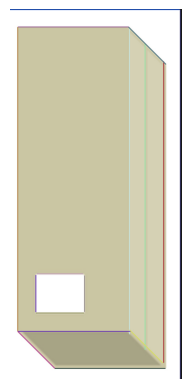

In [10]:
print(len(combine_lines(angle_len_lines)))
image = cv2.imread(r'test_box'+box_number+'.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

for line in combine_lines(angle_len_lines):
    x1, y1, x2, y2, _, _ = line
    cv2.line(image, (x1, y1), (x2, y2), (np.random.randint(255), np.random.randint(255), np.random.randint(255)), 2)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [11]:
lines_list= np.array(combine_lines(angle_len_lines))[:,:4]
lines_list = np.column_stack((lines_list, list(range(len(lines_list)))))
print(lines_list)

[[  29 1228   29   69    0]
 [ 454 1238  454   71    1]
 [ 647 1409  647    3    2]
 [ 584 1347  584  200    3]
 [ 513 1298  513  130    4]
 [ 283 1153  283 1016    5]
 [  98 1154   98 1014    6]
 [  99 1158  280 1158    7]
 [ 102 1009  277 1009    8]
 [  30 1228  461 1228    9]
 [ 170 1369  590 1369   10]
 [   0    2  644    2   11]
 [  31   68  451   68   12]
 [ 455 1223  580 1348   13]
 [ 451   69  592  210   14]
 [  30 1229  169 1368   15]]


C:\Users\ethan\AppData\Local\Temp\ipykernel_9572\2368472232.py:24: RuntimeWarning: overflow encountered in scalar absolute
  if length > existing_line[5] or (abs(slope) < abs(existing_line[4]) and slope != 0):


In [12]:
def are_close(p1, p2, threshold=25):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) <= threshold


In [13]:
G = nx.Graph()

for line in lines_list:
    for line_2 in lines_list:
        if str(line_2) == str(line):
            pass
        p1=(line[0], line[1])
        p2=(line[2], line[3])
        p3=(line_2[0], line_2[1])
        p4=(line_2[2], line_2[3])
        if are_close(p1, p3) or are_close(p1,p4) or are_close(p2, p3) or are_close(p2, p4):
            G.add_edge(line[4], line_2[4])
cycles = nx.simple_cycles(G)
cycles_of_length_4 = [cycle for cycle in cycles if len(cycle) == 4]

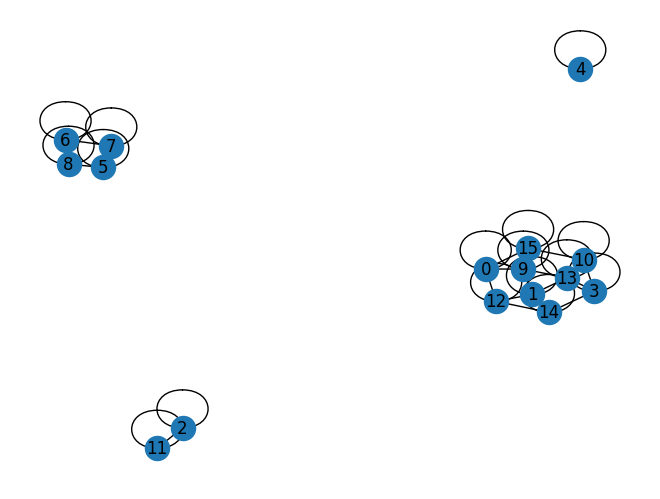

In [14]:
nx.draw(G, with_labels=True)
plt.show()


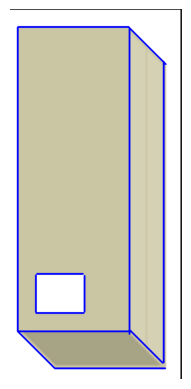

In [15]:
image = cv2.imread(r'test_box'+box_number+'.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

for line in lines_list:
    if line[4] in  sum(cycles_of_length_4, []):#see all boxes present
        x1, y1, x2, y2, _ = line
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 5)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [16]:
box_centers = []
box_edges=[]
for cycle in cycles_of_length_4:# this needs to be fixed it is not picking
    x_point= np.mean([np.mean([lines_list[i][0],lines_list[i][2]])  for i in cycle])
    y_point= np.mean([np.mean([lines_list[i][1],lines_list[i][3]])  for i in cycle])
    x_point_top= np.max([np.max([lines_list[i][0],lines_list[i][2]])  for i in cycle])
    y_point_top= np.max([np.max([lines_list[i][1],lines_list[i][3]])  for i in cycle])
    x_point_min= np.min([np.min([lines_list[i][0],lines_list[i][2]])  for i in cycle])
    y_point_min= np.min([np.min([lines_list[i][1],lines_list[i][3]])  for i in cycle])
    box_centers.append([x_point, y_point])
    box_edges.append([[x_point_min, y_point_top], [x_point_top, y_point_min]])

In [17]:
cycles_of_length_4

[[8, 5, 7, 6], [0, 9, 1, 12], [9, 13, 10, 15], [1, 13, 3, 14]]

190.0 1083.875
242.375 649.75
310.625 1295.25
519.25 713.25


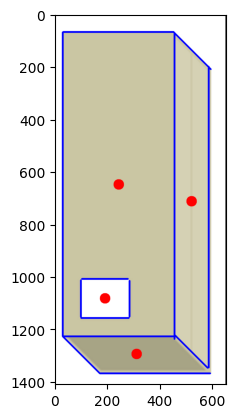

In [18]:

image = cv2.imread(r'test_box'+box_number+'.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
for point in box_centers:
    x, y = point
    print(x,y)
    cv2.circle(image, (int(x), int(y)), radius=20, color=(0, 0, 255), thickness=-1)
for line in lines_list:
    if line[4] in  sum(cycles_of_length_4, []):#see all boxes present
        x1, y1, x2, y2, _ = line
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 5)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.axis('off')
plt.show()

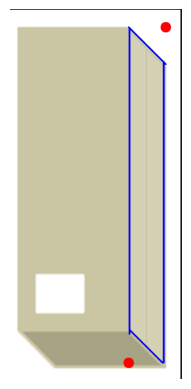

In [19]:
image = cv2.imread(r'test_box'+box_number+'.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
i=3
for point in box_edges[i]:
    x, y = point
    cv2.circle(image, (int(x), int(y)), radius=20, color=(0, 0, 255), thickness=-1)
for line in lines_list:
    if line[4] in  cycles_of_length_4[i]:#see all boxes present
        x1, y1, x2, y2, _ = line
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 5)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [20]:
image_colors = []
image = cv2.imread(r'test_box'+box_number+'.jpg')

for point in box_centers:
    image_colors.append([image[int(point[1]), int(point[0])][2], image[int(point[1]), int(point[0])][1], image[int(point[1]), int(point[0])][0]])
image_colors# see the rgb color of the center of each box, can be used in the future for referencing if the code is white to a brown box

[[255, 255, 255], [202, 198, 163], [167, 164, 133], [205, 200, 168]]

In [21]:
def is_point_inside_box(point, box):
    (x, y), ((x1, y1), (x2, y2)) = point, box
    min_x = min(x1, x2)
    max_x = max(x1, x2)
    min_y = min(y1, y2)
    max_y = max(y1, y2)
    
    return min_x <= x <= max_x and min_y <= y <= max_y

insides = []
for i in range(len(cycles_of_length_4)):
    for j in range(len(cycles_of_length_4)):
        if is_point_inside_box(box_centers[j], box_edges[i]) and i!=j:
            insides.append([i,j])
        
insides

[[1, 0]]

second value is box inside of the box, in this case 3

In [22]:
box_edges[0]

[[98, 1158], [283, 1009]]

In [23]:
box_centers[3]

[519.25, 713.25]

In [24]:
quadrant = np.where(np.multiply(np.array(box_centers[insides[0][1]])-np.array(box_centers[insides[0][0]]),np.array([1,-1]))> 0, 1, -1)

In [25]:
if quadrant[0] == 1:
    if quadrant[1] == 1:
        print('label on top right')
    else:
        print('label on bottom right')
else:
    if quadrant[1] == 1:
        print('label on top left')
    else:
        print('label on bottom left')

label on bottom left
